# Prototyping the Model in Numpy

Now let's simulate our [mathematical model](./tclab_model.ipynb) using numpy.

## Numpy simulation

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt

# known parameters
T_amb = 21             # deg C
alpha = 0.00016        # watts / (units P1 * percent U1)
P1 = 200               # P1 units

# adjustable parameters
CpH = 7                # joules/deg C
CpS = 0.01              # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.001              # watts/deg C

# initial conditions
TH1 = T_amb
TS1 = T_amb
IC = [TH1, TS1]

# input values
U1 = lambda t: 50                # steady state value of u1 (percent)

# extract data from experiment
t_expt = np.linspace(0, 600, 601)

def tclab_ode(theta, U1, T_amb, t_expt, return_data_frame=False):
    ''' ODE system for TCLab

    Arguments:
        theta: list fitted parameters CpH, CpS, Ua, Ub
        U1: function that returns the value of U1 at time t
        T_amb: ambient temperature
        t_expt: time values for the experiment

    '''

    # unpack the adjustable parameters
    Ua, Ub, inv_CpH, inv_CpS = theta

    # right hand side of the ODEs
    def deriv(t, y):
        TH1, TS1 = y
        dTH1 = (-Ua*(TH1 - T_amb) + Ub*(TS1 - TH1) + alpha*P1*U1(t))*inv_CpH
        dTS1 = Ub*(TH1 - TS1)*inv_CpS
        return [dTH1, dTS1]

    # define the initial conditions
    IC = [T_amb, T_amb]

    # numerically integrate the ODEs
    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], IC, t_eval=t_expt) 

    if return_data_frame:
        # create dataframe with predictions
        pred = pd.DataFrame(columns=["Time"])
        pred["Time"] = t_expt
        pred = pred.set_index("Time")
        
        # report the model temperatures
        pred["TH1"] = soln.y[0]
        pred["TS1"] = soln.y[1]
        
        # create dataframe with predictions
        pred = pd.DataFrame(columns=["Time"])
        pred["Time"] = t_expt
        pred["TH1"] = soln.y[0]
        pred["TS1"] = soln.y[1]
        pred["Q1"] = U1(t_expt)
            
        return pred
    else:
        return soln.y[1]
    
pred = tclab_ode(theta=[Ua, Ub, 1/CpH, 1/CpS], 
                 U1=U1,
                 T_amb=T_amb,
                 t_expt=t_expt,
                 return_data_frame=True)
pred

,Time,TH1,TS1,Q1
0,0.0,21.000000,21.000000,50
1,1.0,21.227741,21.011029,50
2,2.0,21.453832,21.042602,50
3,3.0,21.678288,21.092596,50
4,4.0,21.901125,21.157645,50
...,...,...,...,...
596,596.0,52.543808,52.551269,50
597,597.0,52.547056,52.550723,50
598,598.0,52.550280,52.550540,50
599,599.0,52.553480,52.550681,50


<Axes: xlabel='Time / seconds', ylabel='Temperature / deg C'>

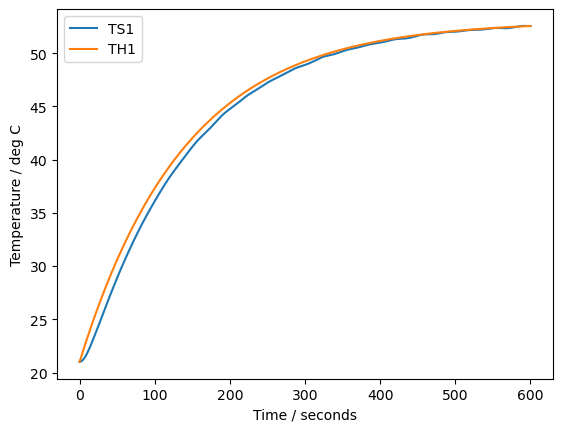

In [2]:
pred[["TS1", "TH1"]].plot(xlabel="Time / seconds", ylabel="Temperature / deg C")

## Parameter estimation: step test

### Load data (step test)

In [3]:
import sys
# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_step_test.csv'"
else:
    file = '../data/tclab_step_test.csv'

df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.84,22.52,50.0,0.0
1,1.01,22.84,22.52,50.0,0.0
2,2.01,22.84,22.52,50.0,0.0
3,3.00,22.84,22.52,50.0,0.0
4,4.00,22.84,22.20,50.0,0.0


### Nonlinear regression and uncertainty analysis

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8913e+02                                    6.09e+04    
       1              2         1.1271e+02      7.64e+01       2.66e+00       9.10e+04    
       2              3         1.0271e+02      9.99e+00       7.29e-01       2.04e+04    
       3              4         1.0193e+02      7.87e-01       6.89e-01       6.67e+02    
       4              5         9.9597e+01      2.33e+00       1.04e+00       3.76e+02    
       5              6         9.8132e+01      1.46e+00       9.89e-01       2.33e+02    
       6              7         9.8109e+01      2.30e-02       1.32e-01       1.07e+00    
       7              8         9.8109e+01      5.94e-05       4.05e-01       8.96e-02    
       8             11         9.8109e+01      2.36e-07       6.73e-01       3.48e+02    
       9             12         9.8109e+01      4.17e-06       4.71e-02       9.89e+01    

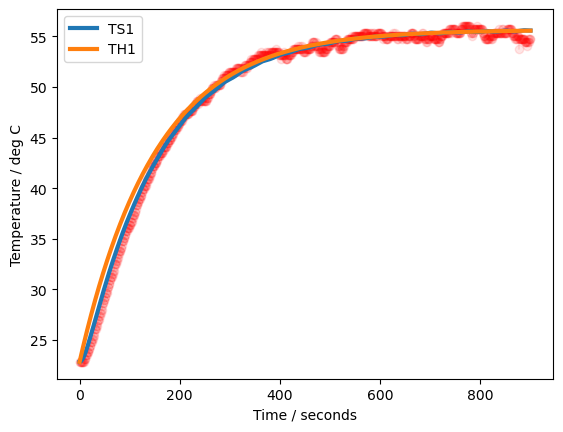

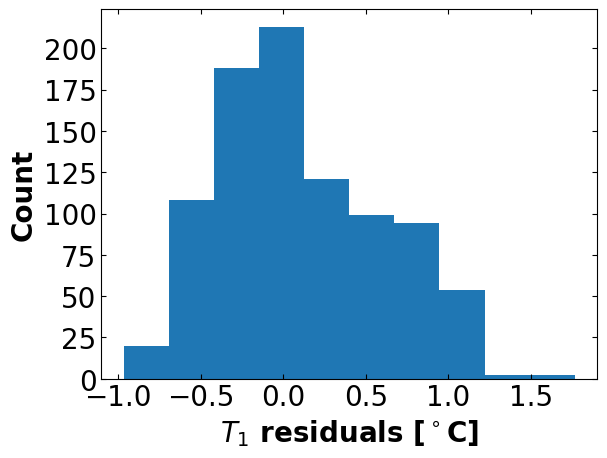

Estimated standard deviation of residuals: 0.504 deg C

Covariance of p = [Ua, Ub, inv_CpH, inv_CpS]
[[ 2.21729357e-09  1.92706741e-08  1.77970810e-08 -1.87455062e-03]
 [ 1.92706741e-08  6.65565947e-05  1.52380571e-05 -6.47154014e+00]
 [ 1.77970810e-08  1.52380571e-05  3.73900020e-06 -1.48171439e+00]
 [-1.87455062e-03 -6.47154014e+00 -1.48171439e+00  6.29251945e+05]]

Correlation matrix
[[ 1.          0.05016372  0.19546069 -0.05018493]
 [ 0.05016372  1.          0.96595369 -0.99999958]
 [ 0.19546069  0.96595369  1.         -0.96599409]
 [-0.05018493 -0.99999958 -0.96599409  1.        ]]


In [4]:
from scipy.optimize import least_squares

def covariance_to_correlation(cov):
    ''' Convert covariance matrix into correlation matrix

    Argument:
        cov: covariance matrix

    Returns:
        cor: correlation matrix

    '''

    # Copy matrix
    cor = cov.copy()

    # Get number of rows
    n = cor.shape[0]

    # Loop over rows
    for r in range(n):
        # Loop over columns
        for c in range(n):
            # Scale element
            cor[r,c] = cor[r,c] / np.sqrt(cov[r,r]*cov[c,c])

    return cor

def perform_regression(data, theta_initial=[Ua, Ub, 1/CpH, 1/CpS]):
    ''' Regress the data to find the parameters Ua, Ub, inv_CpH, inv_CpS

    Arguments:
        data: pandas DataFrame with columns "Time", "Q1", "T1", "T2"
        theta_initial: initial guess for the parameters
    '''

    # Interpolate the constrol signal
    U1 = lambda t: np.interp(t, data["Time"], data["Q1"])

    # Calculate the initial conditions
    T_amb = data.T1.values[0]

    # Assemble y data
    y_data = data["T1"].values

    # Define residual function
    def residuals(p):
        pred = tclab_ode(p, 
                            U1,
                            T_amb, 
                            data["Time"].to_numpy(),
                            return_data_frame=False)
        return pred - y_data
    
    # Set bounds for Ua, Ub, inv_CpH, inv_CpS
    # These are based on physical intuition
    bnds = ([1E-5, 1E-5, 1E-2, 1E-2], [2.0, 2.0, 100, 100])
    
    # Perform least squares nonlinear regression
    nl_results = least_squares(residuals, 
                               theta_initial, 
                               bounds=bnds, 
                               method='trf', 
                               verbose=2, 
                               loss="arctan")
    theta_hat = nl_results.x

    # extract and print values
    Ua, Ub, inv_CpH, inv_CpS = nl_results.x
    CpH = 1/inv_CpH
    CpS = 1/inv_CpS

    print('CpH = ', round(CpH,3), "J/degC")
    print('CpS =', round(CpS,3), "J/degC")
    print('Ua = ', round(Ua,3), "W/degC")
    print('Ub = ', round(Ub, 3), "W/degC")

    # plot the results
    pred = tclab_ode([Ua, Ub, inv_CpH, inv_CpS],
                        U1,
                        T_amb,
                        data["Time"].to_numpy(),
                        return_data_frame=True)
    ax = data["T1"].plot(marker='o',color='red', alpha=0.1)
    pred[["TS1", "TH1"]].plot(ax=ax, linewidth=3, xlabel="Time / seconds", ylabel="Temperature / deg C")
    plt.show()

    # plot the residuals
    r = residuals(nl_results.x)

    # define font size
    fs = 20

    # plot data
    plt.hist(r)
    plt.xlabel("$T_1$ residuals [$^\circ{}$C]",fontsize=fs,fontweight = 'bold')
    plt.ylabel("Count",fontsize=fs,fontweight = 'bold')

    # define tick size
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.tick_params(direction="in",top=True, right=True)

    # finish plot
    plt.show()

    # Estimate covariance and correlation of fitted parameters

    #Estimate covariance of residuals
    var_residuals = r.T@r / (len(r) - len(nl_results.x))
    print("Estimated standard deviation of residuals:",round(np.sqrt(var_residuals),3),"deg C")

    # Estimate covariance of fitted parameters
    cov_p = var_residuals * np.linalg.inv(nl_results.jac.T @ nl_results.jac)


    print("\nCovariance of p = [Ua, Ub, inv_CpH, inv_CpS]")
    print(cov_p)

    print("\nCorrelation matrix")
    print(covariance_to_correlation(cov_p))

    
perform_regression(data=df)

## Parameter estimation: sine test

In [5]:
import sys
# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test.csv'"
else:
    file = '../data/tclab_sine_test.csv'

df2 = pd.read_csv(file)
df2.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8146e+02                                    1.05e+09    
       1              2         2.4374e+02      3.77e+01       4.55e-02       2.21e+07    
       2              3         1.9187e+02      5.19e+01       1.29e-03       5.45e+07    
       3              4         1.8962e+02      2.26e+00       7.43e-03       9.90e+08    
       4              5         1.8835e+02      1.27e+00       2.24e-03       4.14e+06    
       5             12         1.8835e+02      0.00e+00       0.00e+00       4.14e+06    
`xtol` termination condition is satisfied.
Function evaluations 12, initial cost 2.8146e+02, final cost 1.8835e+02, first-order optimality 4.14e+06.
CpH =  7.006 J/degC
CpS = 0.01 J/degC
Ua =  0.051 W/degC
Ub =  0.001 W/degC


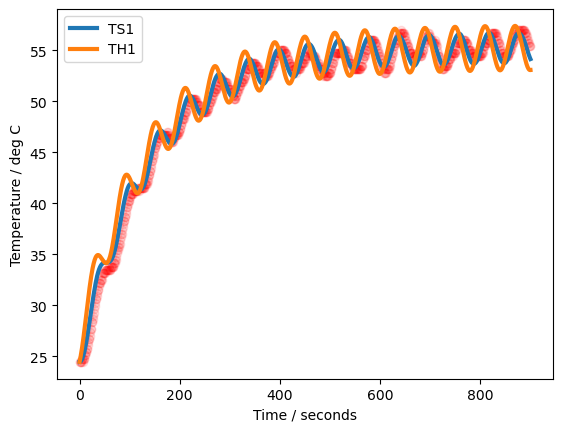

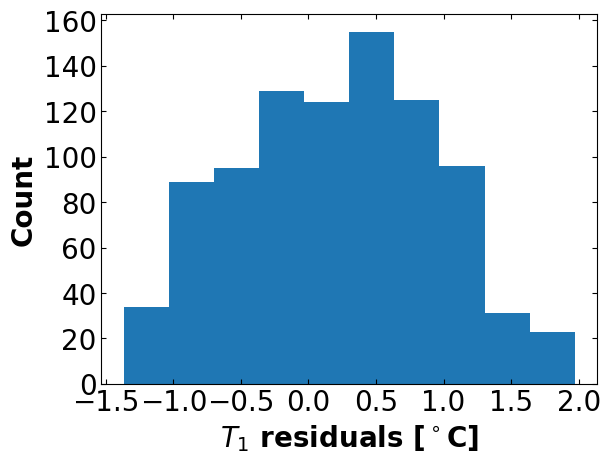

Estimated standard deviation of residuals: 0.761 deg C

Covariance of p = [Ua, Ub, inv_CpH, inv_CpS]
[[ 7.59496466e-10  2.93108955e-14  3.84202866e-13 -7.66852845e-08]
 [ 2.93108955e-14  5.81408881e-16 -1.19782393e-15 -3.13400818e-12]
 [ 3.84202866e-13 -1.19782393e-15  2.00276708e-14 -3.63302486e-11]
 [-7.66852845e-08 -3.13400818e-12 -3.63302486e-11  7.74619517e-06]]

Correlation matrix
[[ 1.          0.04410881  0.09851049 -0.99978113]
 [ 0.04410881  1.         -0.3510241  -0.04669981]
 [ 0.09851049 -0.3510241   1.         -0.0922378 ]
 [-0.99978113 -0.04669981 -0.0922378   1.        ]]


In [6]:
perform_regression(data=df2)

## Take Away Messasge

Numpy is an excellent tool for rapidly protoyping models and performing basic parameter estimation. However, as we saw in this example, numpy was a little slow. Moreover, for the sine wave test, the least squares algorithm got stuck in local solutions. We will see soon how Pyomo is faster for optimization and often leads to more reliable parameter estimation solution.